I started to participate in the Advent of Code 2017 this week. [Advent of Code](http://adventofcode.com) is a good-humored programming competition, both for beginners and experts, centered around a programming puzzle every day in December until Christmas. The problems I've tackled so far have been sometimes simple and sometimes harder, across different aspects of programming. 

One of the problems ([day 3, Spiral Memory](http://adventofcode.com/2017/day/3)) featured the [Ulam Spiral](https://en.wikipedia.org/wiki/Ulam_spiral). While I had come across the spiral before, reading its Wikipedia article made me realize what makes the spiral so attractive to mathematicians: when coloring prime numbers on the spiral, an interesting straight line pattern emerges.

In this post, I'll discuss how the Ulam spiral can be nicely implemented in Python using a generator. We will then use that implementation as an excuse to play with plots and animations of the spiral.

But first: here's the spiral as shown in the puzzle.

```
17  16  15  14  13
18   5   4   3  12
19   6   1   2  11
20   7   8   9  10
21  22  23---> ...
```

# Implementing the spiral 

When I solved the original puzzle, I got stuck a first time which lead me to erase the code I wrote. My second attempt looked like this:

In [1]:
def make_spiral(R):
    """Generates the spiral up to radius R.
    Returns a list of complex numbers (x, y coordinates)."""
    spiral = [(0+0j)]
    for r in range(R+1):
        corner = r - 1j * r
        side_len = 2 * r
        current_pos = corner
        for side, direction in zip(range(4), [1j, -1, -1j, 1]):
            for step in range(side_len):
                current_pos += direction
                spiral.append(current_pos)
    return spiral

This is not particularly good code, but there's one insight that made writing the code easy. 

```
5   4   3  
6   1   2  
7   8   9
```
Consider the numbers 2-9 on the spiral. If you let the numbers start with the 2, you have to step 1 time up, 2 times left, 2 times down and 3 times right. This is not symmetrical.

However, if you let second circle of numbers starts at 9, the steps become: 2 times up, 2 times left, 2 times down, 2 times right. This is easier to implement in my opinion. Hence, I use a "corner" (numbers on the diagonal that goes to the lower right) from which I step into the four directions around the spiral.

This allowed me to get the following plot:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

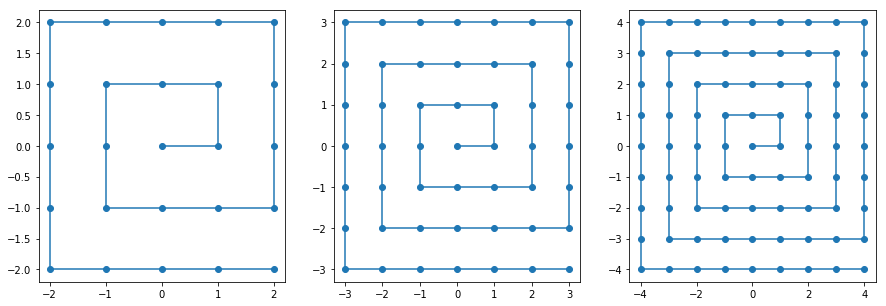

In [3]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)
for ax, r in zip(axes.ravel(), [2, 3, 4]):
    spiral = make_spiral(r)
    ax.plot(np.real(spiral), np.imag(spiral), '-o')

Thanks to one of my friends (Rémi!) I found out that Peter Norvig also publishes his solutions to these puzzles [here](https://github.com/norvig/pytudes/blob/master/ipynb/Advent%202017.ipynb). Since Peter's solutions are, in my opinion, always elegant and efficient at the same time, I checked out his code. Sure enough, I found something that caught my eye: he used a generator to implement the spiral.

So what's a generator? In this case, it's an infinite sequence of steps that can be iterated.

This is very elegant and actually more usable than my approach since you can generate any number of points from the spiral, while my approach limits me to full rings of numbers until "radius" `R`. So I decided to try Norvig's approach and rewrote my algorithm to be a generator:

In [4]:
def spiral_generator():
    "A generator that returns spiral coordinates."
    r = 0
    current = 0+0j
    yield current
    while True:
        r = r + 1
        current = r - 1j * r
        side_len = 2 * r
        for side, direction in enumerate([1j, -1, -1j, 1]):
            for step in range(side_len):
                current += direction
                yield current

How do you use this generator? Well, first you instantiate it and then you can call the `next` method that will yield the next points, like so:

In [5]:
generator = spiral_generator()
for _ in range(10):
    print(next(generator))

0j
(1+0j)
(1+1j)
1j
(-1+1j)
(-1+0j)
(-1-1j)
-1j
(1-1j)
(2-1j)


What if you want to have a list of the items up to a given number? This was what the problem asked for. Peter used something I didn't know, the [`itertools.islice`](https://docs.python.org/3/library/itertools.html#itertools.islice) method. The islice method takes an iterable and returns an iterator that iterates on a slice of it, meaning you can specify where to start and where to end. Calling `list` on that iterable then evaluates the points:

In [6]:
from itertools import islice

In [7]:
list(islice(spiral_generator(), 0, 10))

[0j, (1+0j), (1+1j), 1j, (-1+1j), (-1+0j), (-1-1j), -1j, (1-1j), (2-1j)]

# Plotting more spirals

Using the above implementation, we can do some more graphs. This time, we can directly specify the number of points we want.

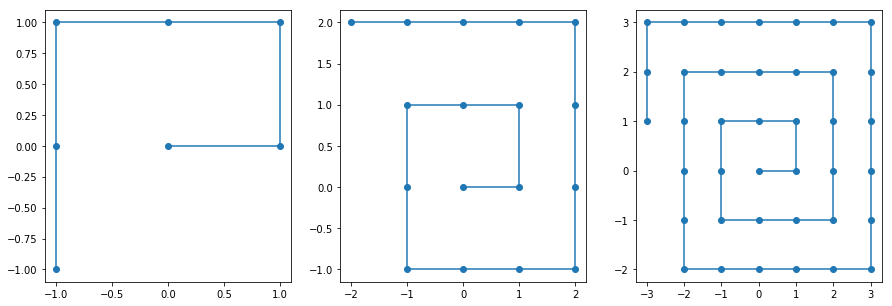

In [8]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)
for ax, n in zip(axes.ravel(), [7, 17, 39]):
    spiral = list(islice(spiral_generator(), 0, n))
    ax.plot(np.real(spiral), np.imag(spiral), '-o')

Let's go further and try to reproduce the spiral that starred on the front page of Scientific American in 1964:

In [9]:
from IPython.display import Image

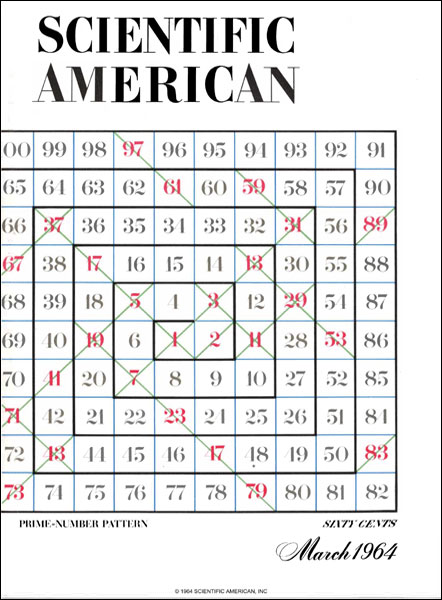

In [10]:
Image('files/Ulam_SciAm_1964_03.jpg')

First, let's try this with circles.

(-5.0, 6.0, -5.0, 6.0)

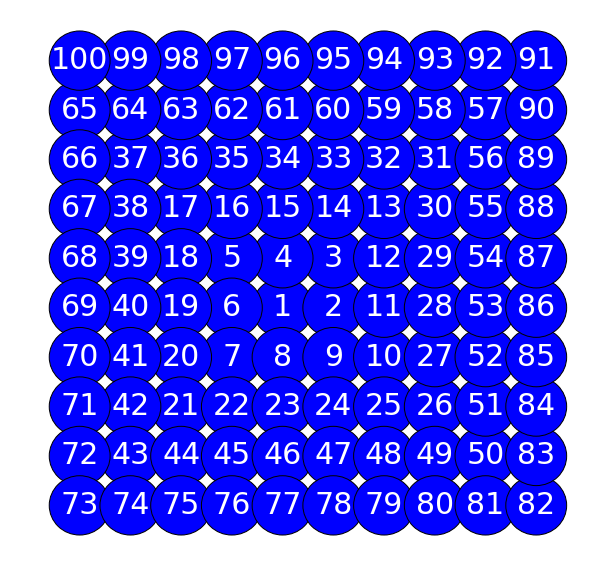

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
for val, coord in enumerate(list(islice(spiral_generator(), 0, 100))):
    circle = plt.Circle((coord.real, coord.imag), radius=0.6, ec='black', color='blue')
    ax.add_artist(circle)
    ax.text(coord.real, coord.imag, s='{}'.format(val+1), ha='center', va='center', color='white', fontsize=30)
plt.xlim(-5, 6)
plt.ylim(-5, 6)
ax.axis('off')

Side note: can you see the [autostereogram](http://flothesof.github.io/making-stereograms-Python.html) inside?

Now, let's color the primes in red.

In [12]:
from sympy import isprime

(-5.0, 6.0, -5.0, 6.0)

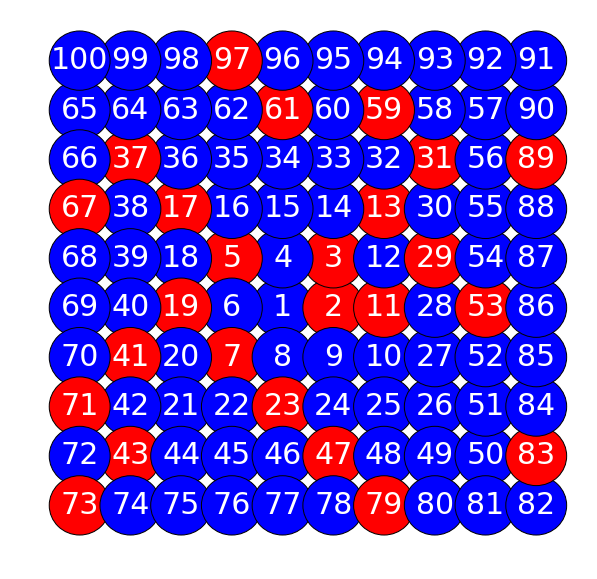

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
for val, coord in enumerate(list(islice(spiral_generator(), 0, 100))):
    if isprime(val+1):
        color = 'red'
    else:
        color = 'blue'
    circle = plt.Circle((coord.real, coord.imag), radius=0.6, ec='black', color=color)
    ax.add_artist(circle)
    ax.text(coord.real, coord.imag, s='{}'.format(val+1), ha='center', va='center', color='white', fontsize=30)
plt.xlim(-5, 6)
plt.ylim(-5, 6)
ax.axis('off')

Let's try a bigger side!

(-10.0, 11.0, -10.0, 11.0)

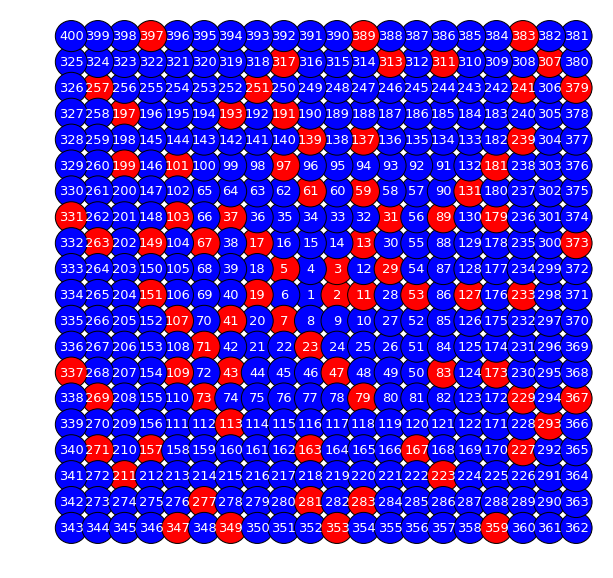

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
side = 20
for val, coord in enumerate(list(islice(spiral_generator(), 0, side**2))):
    if isprime(val+1):
        color = 'red'
    else:
        color = 'blue'
    circle = plt.Circle((coord.real, coord.imag), radius=0.6, ec='black', color=color)
    ax.add_artist(circle)
    ax.text(coord.real, coord.imag, s='{}'.format(val+1), ha='center', va='center', color='white', fontsize=13)
plt.xlim(-side/2, side/2+1)
plt.ylim(-side/2, side/2+1)
ax.axis('off')

What if we switch the circles to rectangles?

(-10.0, 11.0, -10.0, 11.0)

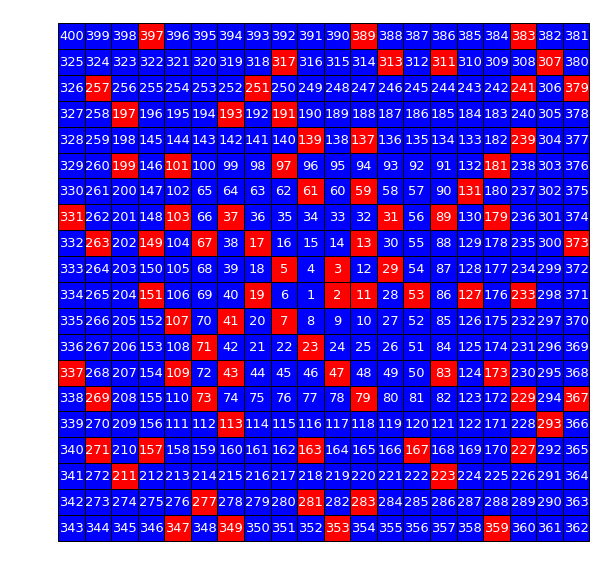

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
side = 20
for val, coord in enumerate(list(islice(spiral_generator(), 0, side**2))):
    if isprime(val+1):
        color = 'red'
    else:
        color = 'blue'
    rect = plt.Rectangle((coord.real-0.5, coord.imag-0.5), width=1., height=1., angle=0, ec='black', color=color)
    ax.add_artist(rect)
    ax.text(coord.real, coord.imag, s='{}'.format(val+1), ha='center', va='center', color='white', fontsize=13)
plt.xlim(-side/2, side/2+1)
plt.ylim(-side/2, side/2+1)
ax.axis('off')

Wait, there's an option to rotate rectangles in `matplotlib.patches.Rectangle`!

(-10.0, 11.0, -10.0, 11.0)

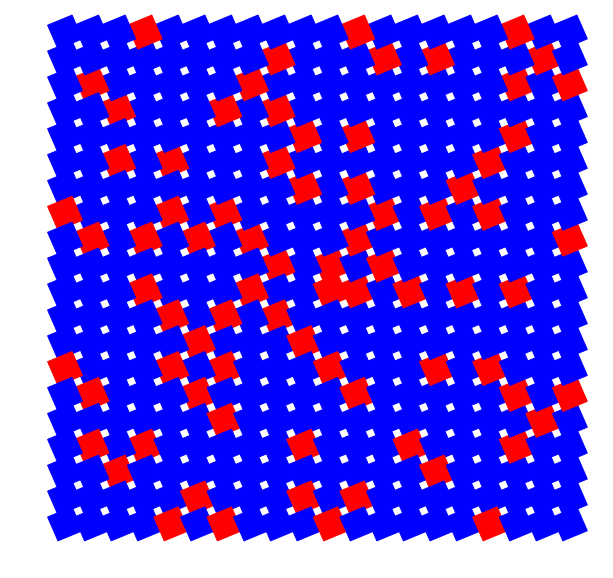

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
side = 20
for val, coord in enumerate(list(islice(spiral_generator(), 0, side**2))):
    if isprime(val+1):
        color = 'red'
    else:
        color = 'blue'
    rect = plt.Rectangle((coord.real-0.5, coord.imag-0.5), width=1., height=1., angle=23, color=color)
    ax.add_artist(rect)
plt.xlim(-side/2, side/2+1)
plt.ylim(-side/2, side/2+1)
ax.axis('off')

At this point, I'm wondering: what if these things were turning?

In [17]:
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

duration = 2
fig, ax = plt.subplots(figsize=(10, 10))
def make_frame(t):
    ax.clear()
    angle = t/duration * 360
    side = 20
    for val, coord in enumerate(list(islice(spiral_generator(), 0, side**2))):
        if isprime(val+1):
            color = 'red'
        else:
            color = 'blue'
        rect = plt.Rectangle((coord.real-0.5, coord.imag-0.5), width=1., height=1., angle=angle, color=color)
        ax.add_artist(rect)
    ax.set_xlim(-side/2, side/2+1)
    ax.set_ylim(-side/2, side/2+1)
    ax.axis('off')
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
plt.close(fig)
animation.ipython_display(fps=20, loop=True, autoplay=True)

 98%|█████████▊| 40/41 [00:19<00:00,  2.26it/s]


Mmh, this looks quite crowded. Let's try less squares.

In [18]:
duration = 2
fig, ax = plt.subplots(figsize=(10, 10))
def make_frame(t):
    ax.clear()
    angle = t/duration * 360
    side = 10
    for val, coord in enumerate(list(islice(spiral_generator(), 0, side**2))):
        if isprime(val+1):
            color = 'red'
        else:
            color = 'blue'
        circle = plt.Rectangle((coord.real-0.5, coord.imag-0.5), width=1., height=1., angle=angle, color=color)
        ax.add_artist(circle)
    ax.set_xlim(-side/2, side/2+1)
    ax.set_ylim(-side/2, side/2+1)
    ax.axis('off')
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
plt.close(fig)
animation.ipython_display(fps=20, loop=True, autoplay=True)

 98%|█████████▊| 40/41 [00:06<00:00,  8.02it/s]


Well, I'll stop the exploration here. These animations remind me of Bees and Bombs. If you don't know what I'm talking about, visit Bees and Bombs here: <https://beesandbombs.tumblr.com>!

*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20171208_AdventOfCodeAndUlamsSpiral.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20171208_AdventOfCodeAndUlamsSpiral.ipynb).*